## Theano

In [1]:
import theano
from theano import tensor as T

In [2]:
# initialize
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# compile
net_input = theano.function(inputs = [w1, x1, w0], outputs = z1)

# execute
print('Net input: %.2f' % net_input(2.0, 1.0, .5))

Net input: 2.50


## configurations

In [3]:
# Theano config
print theano.config.floatX

float64


In [4]:
theano.config.floatX = 'float32'
print theano.config.floatX
# theano.config.floatX = 'float64'
# print theano.config.floatX

float32


In [5]:
print theano.config.device

cpu


## array structures

In [6]:
import numpy as np

# initialize
x = T.fmatrix(name = 'x')
x_sum = T.sum(x, axis = 0)

# compile
calc_sum = theano.function(inputs = [x], outputs = x_sum)

# execute Python list
ary = [[1, 2, 3], [1, 2, 3]]
print 'Column sum:', calc_sum(ary)

# execute NumPy array
ary = np.array([[1, 2, 3], [1, 2, 3]], 
               dtype = 'float32')
print 'Column sum:', calc_sum(ary)

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


## memory sharing

In [7]:
x = T.fmatrix('x')
w = theano.shared(np.array([[.0, .0, .0]], dtype = 'float32'))
z = x.dot(w.T)
update = [[w, w + 1.0]]

net_input = theano.function(inputs = [x], updates = update, outputs = z)

data = np.array([[1, 2, 3]], dtype = 'float32')

for i in range(5):
    print 'z%d:' % i, net_input(data)

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


## use the givens variable to keep data on the GPU if it fits into the memory

In [8]:
data = np.array([[1, 2, 3]], dtype = 'float32')

x = T.fmatrix('x')

w = theano.shared(np.asarray([[.0, .0, .0]], dtype = 'float32'))

z = x.dot(w.T)

update = [[w, w + 1.0]]

net_input = theano.function(inputs = [], updates = update, givens = {x: data}, outputs = z)

for i in range(5):
    print 'z%d :' % i, net_input()

z0 : [[ 0.]]
z1 : [[ 6.]]
z2 : [[ 12.]]
z3 : [[ 18.]]
z4 : [[ 24.]]


## a linear regression

In [9]:
# data
X_train = np.asarray([[.0], [1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7.0], [8.0], [9.0]], dtype = 'float32')
y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype = 'float32')

In [10]:
def train_linreg(X_train, y_train, eta, epochs):
    costs = []
    # initialize
    eta0 = T.fscalar(name='eta0')
    y = T.fvector(name='y')
    X = T.fmatrix(name='X')
    w = theano.shared(np.zeros(shape = (X_train.shape[1] + 1), dtype = 'float32'), name = 'w')
    
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2))
    
    # gradient update
    gradient = T.grad(cost, wrt = w)
    update = [(w, w - eta0 * gradient)]
    
    # compile model
    train = theano.function(inputs=[eta0], outputs=cost, updates=update, givens={X:X_train, y:y_train})
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

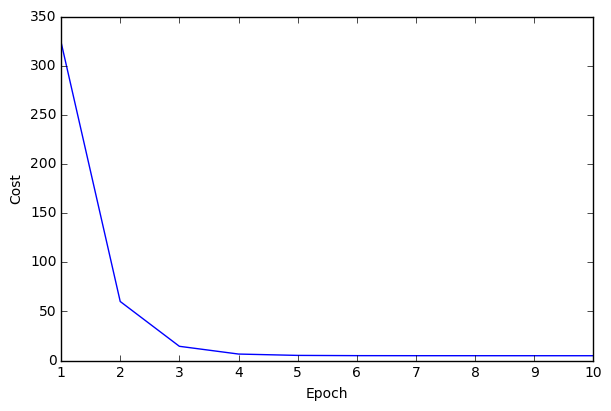

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

costs, w = train_linreg(X_train, y_train, eta = .001, epochs = 10)

plt.plot(range(1, len(costs)+1), costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

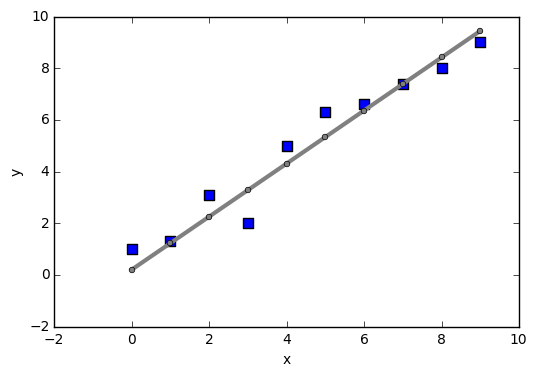

In [12]:
def predict_linreg(X, w):
    Xt = T.fmatrix(name = 'X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w:w}, outputs=net_input)
    return predict(X)

plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), predict_linreg(X_train, w), color='grey', marker='o', markersize=4, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Keras

In [13]:
import struct
import os

def load_mnist(path, kind):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

In [14]:
X_train, y_train = load_mnist('./data/MNIST_data/', 'train')
print 'Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1])
X_test, y_test = load_mnist('./data/MNIST_data/', 't10k')
print 'Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1])

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [15]:
# convert data type into float 32 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [16]:
# switch Keras backend: https://keras.io/backend/
# convert class labels into one-hot format
from keras.utils import np_utils

print 'First 3 labels: ', y_train[:3]

y_train_ohe = np_utils.to_categorical(y_train)
print 'First 3 labels (one-hot):', '\n' , y_train_ohe[:3]

Using Theano backend.


First 3 labels:  [5 0 4]
First 3 labels (one-hot): 
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [17]:
# model setup
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], 
               output_dim = 50, 
               init = 'uniform',
               activation = 'tanh'))

model.add(Dense(input_dim=50,
               output_dim=50,
               init='uniform',
               activation='tanh'))

model.add(Dense(input_dim=50,
               output_dim=y_train_ohe.shape[1],
               init='uniform',
               activation='softmax'))

sgd = SGD(lr = .001, decay = 1e-7, momentum = .9)

model.compile(loss = 'categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# training
model.fit(X_train, 
         y_train_ohe,
         nb_epoch = 50,
         batch_size = 300,
         verbose = 1,
         validation_split = .1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
18600/54000 [=========>....................] - ETA: 2s - loss: 2.2836